# Bayesian Neural Networks (BNNs)

In this notebook a Bayesian Neural network is trained on the CFB data to take bridge parameter as input an predict the code compliance factors.

### Resources
Here you can find nice explanations: 

1. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut1_students_with_answers.html

The following source was used as a stating point for the implementation:

2. https://towardsdatascience.com/from-theory-to-practice-with-bayesian-neural-network-using-python-9262b611b825 

### Content
1. Data Import
2. Data Pre-processing
3. Setup and Train Model
4. Model Perfromance Evaluation
5. 1D Parameter Studies


In [1]:
#import necessary libraries
import pandas as pd
import math as m
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
from torch.utils.data import DataLoader, TensorDataset

import json

In [2]:
### Initialise Training study tracking dict
# initialise whole dict (only run once per study)
eval_dict={}
dict_name='Study_1_Antoine'

# # load_evaluation dict
# dict_name='Study_0_Antoine'
# with open('trainedModels\\{}.json'.format(dict_name), 'r') as file:
#     eval_dict = json.load(file)

In [246]:
dict_name='Study_1_Antoine'
# Initialize an empty list to hold the rows
rows = []

# Initialize an empty list to hold the column headers
columns = []

# Loop through the nested dictionary to build rows and columns
for key, subdict in eval_dict.items():
    row = {}
    for subkey, subsubdict in subdict.items():
        for subsubkey, value in subsubdict.items():
            column = (subkey, subsubkey)  # subkey and subsubkey as the column header
            row[column] = value
            if column not in columns:
                columns.append(column)  # Collect all unique columns
    rows.append((key, row))

# Create a DataFrame with the columns and rows, using the key as the index
df = pd.DataFrame([row for _, row in rows], index=[key for key, _ in rows])

# Set multi-level columns (subkey, subsubkey)
df.columns = pd.MultiIndex.from_tuples(columns)

# Display the DataFrame
df.to_excel("trainedModels/{}.xlsx".format(dict_name))

## 1.  Data Import 

Data is imported from the defined csv file to a pandas Data Frame.

In [3]:
####### load values #######

# data_batch=1001
# train_df = pd.read_csv("trainingData/{}_CFB_xy_train.csv".format(data_batch))
# val_df = pd.read_csv("trainingData/{}_CFB_xy_validation.csv".format(data_batch))
# test_df = pd.read_csv("trainingData/{}_CFB_xy_test.csv".format(data_batch))

data_batch='1001_1002_1003'
train_df = pd.read_csv("trainingData/1001_1002_1003_CFB_xy_train.csv")
val_df = pd.read_csv("trainingData/1001_CFB_xy_validation.csv")
test_df = pd.read_csv("trainingData/1001_CFB_xy_test.csv")

# Select features
x_names = ['L', 'b1',  't_p', 't_w', 'h_w', 'd1_plate', 'd4_plate', 'd2_plate', 's_plate', 'd1_walls', 'd4_walls', 's_walls', 'fcc', 's', 'beta', 'h_G'] # all 16 features
# Select target(s)
y_names=['eta_min_s']

x_train_df = train_df[x_names]
y_train_df = train_df[y_names]
x_val_df = val_df[x_names]
y_val_df = val_df[y_names]
x_test_df = test_df[x_names]
y_test_df = test_df[y_names]

# transfrom to numpy arrays
x_train_np = x_train_df.values
y_train_np = y_train_df.values
x_val_np = x_val_df.values
y_val_np = y_val_df.values
x_test_np = x_test_df.values
y_test_np = y_test_df.values

#Print shapes of the splitted data sets
print('Training Dataset: ',x_train_df.shape,y_train_df.shape )
print('Validation Dataset: ',x_val_df.shape, y_val_df.shape)
print('Test Dataset: ',x_test_df.shape,y_test_df.shape)



####### needed for the scaler #######
x_data_df = pd.concat([x_train_df, x_val_df, x_test_df], axis=0, ignore_index=True)
print('Total Dataset: ',x_data_df.shape )
total_data_set_size=x_data_df.shape[0]

Training Dataset:  (6709, 16) (6709, 1)
Validation Dataset:  (962, 16) (962, 1)
Test Dataset:  (1202, 16) (1202, 1)
Total Dataset:  (8873, 16)


## 2. Pre-process Data

Pre-Processing Steps
- select x and y columns (inputs and outputs)
- split data set in trianing and test set
- transform data to same range with MinMaxScaler
- transform scaled data to troch tensors

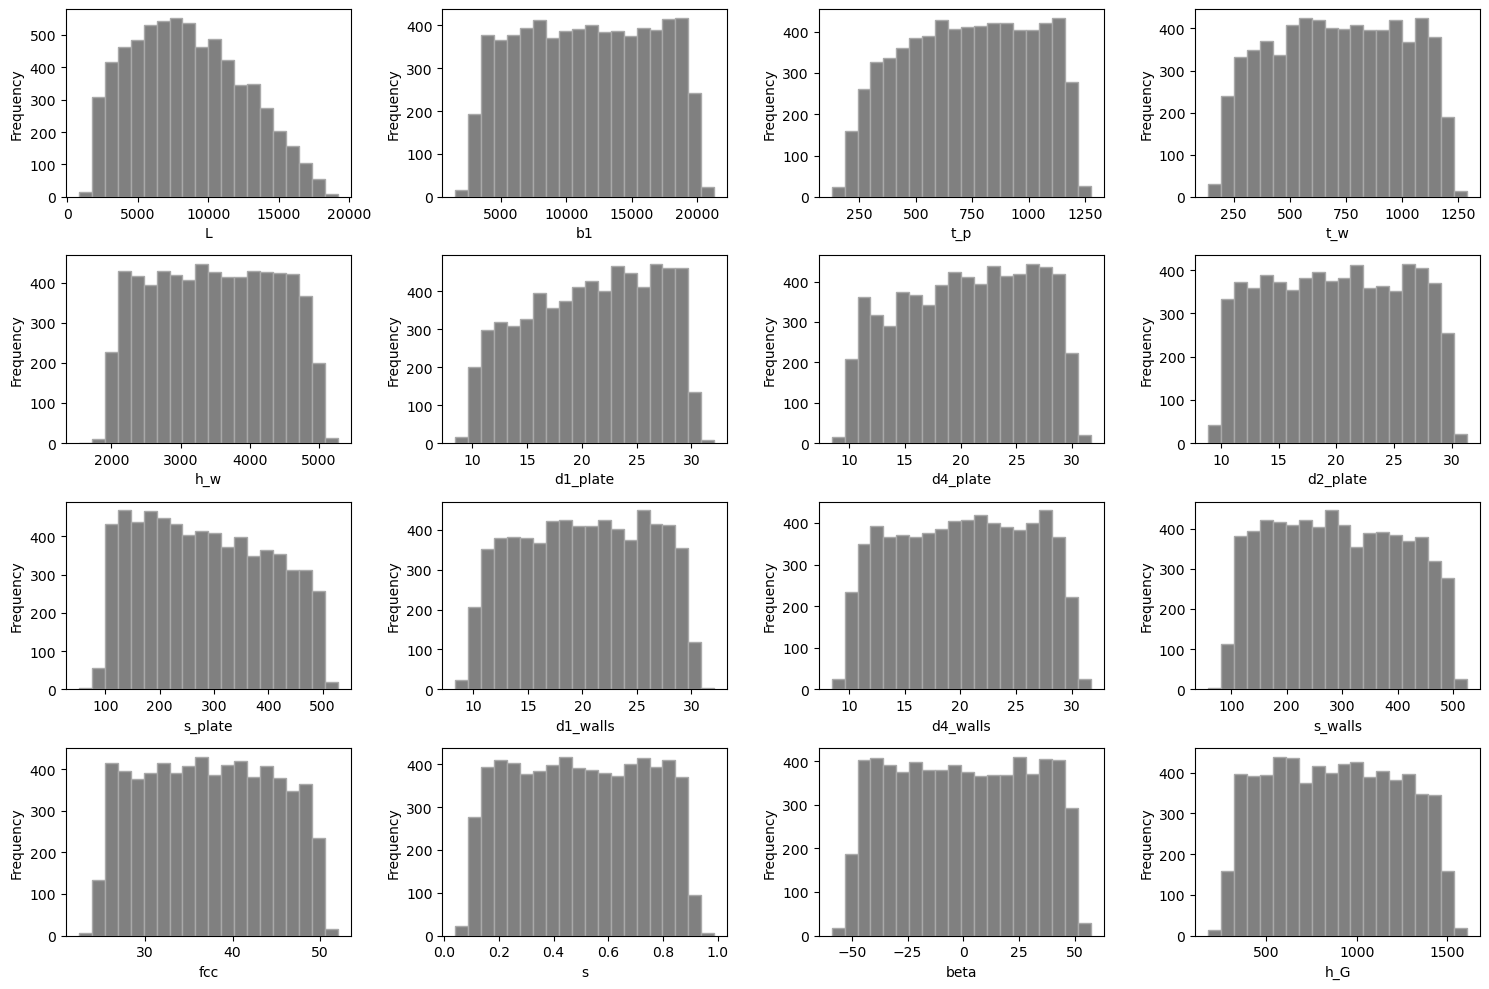

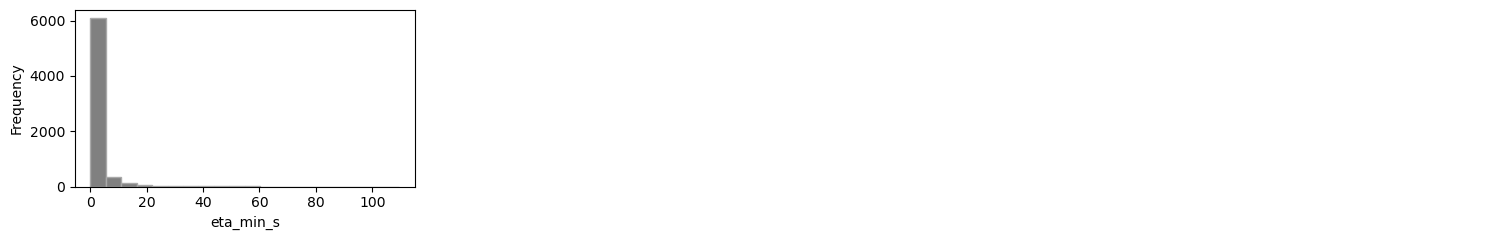

In [4]:
from plotting import hist_matrix
hist_matrix(x_train_df)
hist_matrix(y_train_df)

In [5]:
###### Scaling of data ######

# INPUT we scale to a range 0,1
# Initialize the MinMaxScaler and fit it on the training data
# Note: MinMaxScaler  scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
# Note: MinMaxScaler doesn’t reduce the effect of outliers, but it linearly scales them down into a fixed range
# Note: MinMaxScaler is sufficient as our data is uniformily distributed for the case when we have non-uniform distirbuted data (as sampled with )

#initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# fit scaler on total data set
scaler.fit(x_data_df)

# scale training data
x_train_scaled_np = scaler.transform(x_train_df)
x_train_scaled_df=pd.DataFrame(data=x_train_scaled_np, columns=scaler.get_feature_names_out())

# Scale the validation data using the same scaler
x_val_scaled_np = scaler.transform(x_val_df)
x_val_scaled_df=pd.DataFrame(data=x_val_scaled_np, columns=scaler.get_feature_names_out())

# Scale the validation data using the same scaler
x_test_scaled_np = scaler.transform(x_test_df)
x_test_scaled_df=pd.DataFrame(data=x_test_scaled_np, columns=scaler.get_feature_names_out())

#plot scaled data
x_train_scaled_df.describe()

,L,b1,t_p,t_w,h_w,d1_plate,d4_plate,d2_plate,s_plate,d1_walls,d4_walls,s_walls,fcc,s,beta,h_G
count,6709.000000,6709.000000,6709.000000,6709.000000,6709.000000,6709.000000,6709.000000,6709.000000,6709.000000,6709.000000,6709.000000,6709.000000,6709.000000,6709.000000,6709.000000,6709.000000
mean,0.420915,0.508322,0.527237,0.503597,0.521734,0.524375,0.520977,0.495978,0.488807,0.498378,0.505421,0.502520,0.501992,0.486077,0.506845,0.493369
std,0.213399,0.249574,0.243474,0.245332,0.231092,0.241370,0.246396,0.257044,0.241670,0.240607,0.248686,0.243798,0.243601,0.246465,0.253566,0.240984
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.249199,0.293976,0.328189,0.302168,0.322873,0.324374,0.315266,0.273968,0.279978,0.294167,0.292946,0.294337,0.293369,0.272904,0.287709,0.285508
50%,0.403940,0.509923,0.533925,0.506268,0.519853,0.539638,0.532186,0.496400,0.474745,0.501567,0.511092,0.493383,0.498509,0.483691,0.502995,0.493761
75%,0.576777,0.725982,0.736892,0.714090,0.721533,0.734746,0.733000,0.721299,0.692619,0.707680,0.719432,0.708859,0.710261,0.701240,0.728244,0.696429
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Note instead of scaling the data here I inlcuded a mean squared log error loss in my training which has the same effect but no need for preprocessing and postprocing of training input and prediction output
# ###### Scaling of data ######

# # Y (Output) we scale with log(y)
# #m.log(y_train_np)

# # Applying y_trans=log_e(y+1) function/ transformation
# y_train_transf_np = np.log(y_train_np + 1) # log_e
# y_train_transf_df=pd.DataFrame(y_train_transf_np, columns=y_names)

# y_val_transf_np = np.log(y_val_np + 1) # log_e
# y_val_transf_df=pd.DataFrame(y_val_transf_np, columns=y_names)


# hist_matrix(y_train_transf_df)


# ##### convert to troch tensors ######

# # convert data to toch tensors (as needed format for BNN model)
# x_train_scaled_tensor=torch.tensor(x_train_scaled_df.values, dtype=torch.float32)
# y_train_transf_tensor=torch.tensor(y_train_transf_df.values, dtype=torch.float32)

# x_val_scaled_tensor=torch.tensor(x_val_scaled_df.values, dtype=torch.float32)
# y_val_transf_tensor=torch.tensor(y_val_transf_df.values, dtype=torch.float32)

In [7]:
##### convert to troch tensors ######

# convert data to toch tensors (as needed format for BNN model)
#training data
x_train_scaled_tensor=torch.tensor(x_train_scaled_df.values, dtype=torch.float32)
y_train_tensor=torch.tensor(y_train_df.values, dtype=torch.float32)

#validation data
x_val_scaled_tensor=torch.tensor(x_val_scaled_df.values, dtype=torch.float32)
y_val_tensor=torch.tensor(y_val_df.values, dtype=torch.float32)

#test data
x_test_scaled_tensor=torch.tensor(x_test_scaled_df.values, dtype=torch.float32)
y_test_tensor=torch.tensor(y_test_df.values, dtype=torch.float32)


## 3. Setup and Train Model

- Define NN Architecture
- Define Losses
- Trianing Loop
- Plot loss developement during trianing
- save trained model

In [227]:
# define NN architecture
layers=6
width=[16, 40, 40, 40, 40, 40]
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=40),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=40, out_features=40),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=40, out_features=40),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=40, out_features=40),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=40, out_features=40),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=40, out_features=1),
    nn.ReLU()
)


#initialize error tracking lists
mse_list=[]
mse_val_list=[]

msle_list=[]
msle_val_list=[]

mean_mse_list=[]
mean_mse_val_list=[]

weighted_mse_list = []
weighted_mse_val_list = []

rmse_list=[]
rmse_val_list=[]

kl_list=[]
kl_val_list=[]

mape_list=[]
mape_val_list=[]

custom_loss_list = []
custom_loss_val_list = []


In [228]:
##### Losses ######

#get loss functions
# get kl loss
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
# get mse loss
mse_loss = nn.MSELoss()

#import losses
from MLmodel import  weighted_mse_loss, msle_loss, mape_loss,custom_loss





In [229]:
### Define other hyperparameters

# define kl weight for weighing of kl_loss in total loss function
# Note: depending which loss function are used different kl_weights should be chosen...msle is of a multiple magnitude smaller than the mse, so the kl_weight hast to also be adapter when we use that weight.
# Note: with mse loss 0.01, with msle loss 0.0001
kl_weight = 0.001

#get optimizer
learning_rate=0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# define epochs, and the training data, and the batch size
epochs = 500
batch_size = 32

#loss function hyperparameters for weighted mse loss
wMSE_loss_importance_range=(0.1,2)
wMSE_loss_high_weight=1000


In [230]:
### save model training settings to eval_dict

#define model name:
# name rule: batch_filter_modeldepth_width_lossfunction_epochs_iteration
model_name='1001_1002_1003_no0_6_20_rmse_weighted_mse_400_300_0'  # define manually

# initialize model dict
eval_dict[model_name]={} 
eval_dict[model_name]['model_settings']={}
eval_dict[model_name]['training_set_performance']={}
eval_dict[model_name]['validation_set_performance']={}

# save model settings
eval_dict[model_name]['model_settings']['batch']=data_batch
eval_dict[model_name]['model_settings']['filtered']="without zero etas" # define manually
eval_dict[model_name]['model_settings']['total_data_size']=total_data_set_size
eval_dict[model_name]['model_settings']['test_split']=0.2 # define manually
eval_dict[model_name]['model_settings']['val_split']=0.2 # define manually
eval_dict[model_name]['model_settings']['layers']=layers
eval_dict[model_name]['model_settings']['width']=width

eval_dict[model_name]['model_settings']['loss']=['rmse', 'weighted mse'] # define manually
eval_dict[model_name]['model_settings']['wMSE_loss_importance_range']=wMSE_loss_importance_range
eval_dict[model_name]['model_settings']['wMSE_loss_high_weight']=wMSE_loss_high_weight

# eval_dict[model_name]['model_settings']['loss']='cost_weighted_mse' # define manually
# eval_dict[model_name]['model_settings']['loss_importance_range']=(0.1,3) # define manually
# eval_dict[model_name]['model_settings']['loss_high_weight']=100 # define manually
eval_dict[model_name]['model_settings']['kl_weight']=kl_weight
eval_dict[model_name]['model_settings']['learning_rate']=[0.001,0.001]#learning_rate
eval_dict[model_name]['model_settings']['epochs']=[400,300]#epochs
eval_dict[model_name]['model_settings']['batch_size']=batch_size
# eval_dict

In [231]:
### training loop 

# Shuffle is set to True to randomize the order of training data at each epoch
train_dataset = TensorDataset(x_train_scaled_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# x = x_train_scaled_tensor
# y = y_train_transf_tensor
with_stochasticPrediction=False

#training loop
for step in range(epochs):
    
    model.train()

    epoch_mse = []
    epoch_msle = []
    epoch_weighted_mse = []
    epoch_rmse = []
    epoch_kl = []
    epoch_mape = []
    epoch_custom = []

    for x, y in train_loader:
        y_pred = model(x)

        if with_stochasticPrediction:
            y_pred_mean_np, y_pred_std_np, y_pred_n_times=bnn_predict_with_uncertainty(model, x, n=100)
            y_pred_mean_tensor=torch.tensor(y_pred_mean_np, dtype=torch.float32)
            mean_mse = mse_loss(y_pred_mean_tensor, y)
            mean_mse_list.append(mean_mse.item())
            
        #standard mse, rmse loss
        mse = mse_loss(y_pred, y)
        epoch_mse.append(mse.item())
        # mse_list.append(mse.item())
        rmse = torch.sqrt(mse)
        epoch_rmse.append(rmse.item())

        #msle loss
        msle = msle_loss(y_pred, y,base='10')
        epoch_msle.append(msle.item())
        # msle_list.append(msle.item())

        # weighted MSE loss
        weighted_mse = weighted_mse_loss(y_pred, y, importance_range=wMSE_loss_importance_range, high_weight=wMSE_loss_high_weight)
        epoch_weighted_mse.append(weighted_mse.item())
        # custom_mse_list.append(custom_mse.item())

        # mape
        mape= mape_loss(y_pred, y)
        epoch_mape.append(mape.item())


        # # Custom loss
        custom = custom_loss(y_pred, y, threshold=0.5, alpha=1, beta=1)
        epoch_custom.append(custom.item())

        #kl_divergence loss
        kl = kl_loss(model)
        epoch_kl.append(kl.item())
        # kl_list.append(kl.item())

        # Add individual losses weighted to single loss
        cost = rmse + kl_weight*kl
        cost_log=msle + kl_weight*kl
        cost_weighted_mse= weighted_mse + kl_weight*kl
        cost_mape = mape + kl_weight*kl
        cost_custom=custom + kl_weight*kl
        
        optimizer.zero_grad()
        cost_weighted_mse.backward() #Specify loss that should be used here
        optimizer.step()

    # Calculate mean losses for the epoch (on training data) and save in loss lists
    mse_list.append(np.mean(epoch_mse))
    rmse_list.append(np.mean(epoch_rmse))
    msle_list.append(np.mean(epoch_msle))
    weighted_mse_list.append(np.mean(epoch_weighted_mse))
    kl_list.append(np.mean(epoch_kl))
    mape_list.append(np.mean(epoch_mape))
    custom_loss_list.append(np.mean(epoch_custom))

    # Calculate validation loss calculation and save in loss tracking lists
    model.eval()
    with torch.no_grad():
        y_val_pred = model(x_val_scaled_tensor)

        #standard mse, rmse loss
        mse_val = mse_loss(y_val_pred, y_val_tensor)
        mse_val_list.append(mse_val.item())
        rmse_val = torch.sqrt(mse_val)
        rmse_val_list.append(rmse_val.item())

        #msle los
        msle_val = msle_loss(y_val_pred, y_val_tensor, base='10')
        msle_val_list.append(msle_val.item())

        # weighted MSE loss
        weighted_mse_val = weighted_mse_loss(y_val_pred, y_val_tensor, importance_range=(0, 4), high_weight=10)
        weighted_mse_val_list.append(weighted_mse_val.item())

        # mape loss
        mape_val = mape_loss(y_val_pred, y_val_tensor)
        mape_val_list.append(mape_val.item())

        # custom loss
        custom_val = custom_loss(y_val_pred, y_val_tensor, threshold=0.5, alpha=1, beta=1)
        custom_loss_val_list.append(custom_val.item())
        

            

    # verbalise
    if step % 50 == 0:
        if with_stochasticPrediction:
            print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, Mean MSE: {mean_mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
                f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}; '
                'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
                f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')
        else: 
            print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
                f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}; '
                'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
                f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')

    

    


print('Training is finished. The final losses:') 
if with_stochasticPrediction:
    print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, Mean MSE: {mean_mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
          f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}, '
          'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
          f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')
else:
    print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
          f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}, '
          'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
          f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')

Step 0, On Training Set: MSE: 8163.66, MSLE: 1.17, KL: 0.33, RMSE: 90.35, Weighted MSE: 8163.66, MAPE: 87.50, Custom Loss: 0.88; On Validation Set: Val MSE: 1129.95, Val MSLE: 0.68, Val RMSE: 33.61, Val Weighted MSE: 1135.50, Val MAPE: 108.87, Val Custom Loss: 0.79
Step 50, On Training Set: MSE: 82.07, MSLE: 0.20, KL: 0.95, RMSE: 9.06, Weighted MSE: 94.78, MAPE: 132.40, Custom Loss: 0.66; On Validation Set: Val MSE: 207.11, Val MSLE: 0.12, Val RMSE: 14.39, Val Weighted MSE: 212.27, Val MAPE: 101.47, Val Custom Loss: 0.59
Step 100, On Training Set: MSE: 36.52, MSLE: 0.12, KL: 1.46, RMSE: 6.04, Weighted MSE: 36.52, MAPE: 57.24, Custom Loss: 0.57; On Validation Set: Val MSE: 85.51, Val MSLE: 0.06, Val RMSE: 9.25, Val Weighted MSE: 89.52, Val MAPE: 87.35, Val Custom Loss: 0.49
Step 150, On Training Set: MSE: 14.05, MSLE: 0.02, KL: 2.00, RMSE: 3.75, Weighted MSE: 14.05, MAPE: 26.33, Custom Loss: 0.26; On Validation Set: Val MSE: 119.64, Val MSLE: 0.10, Val RMSE: 10.94, Val Weighted MSE: 124

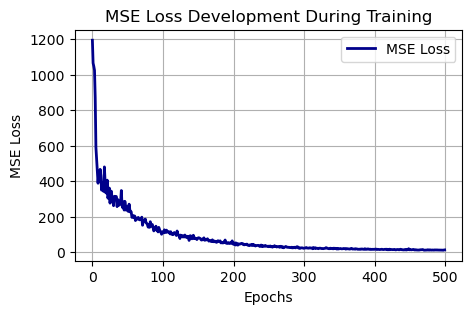

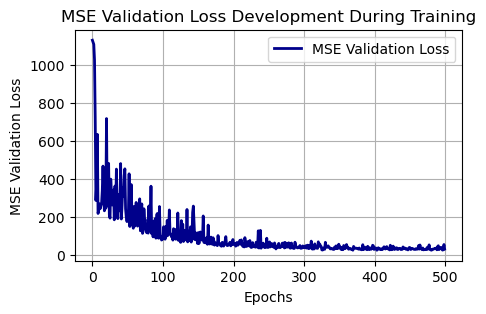

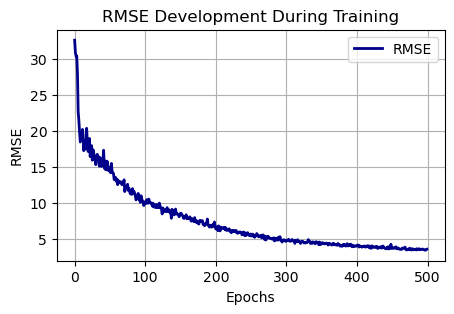

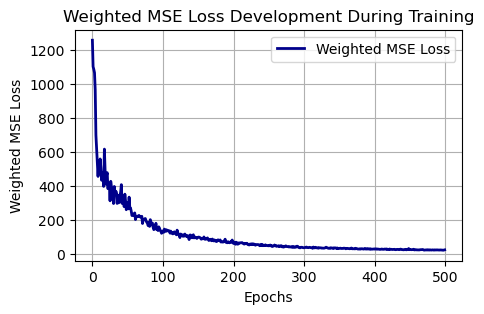

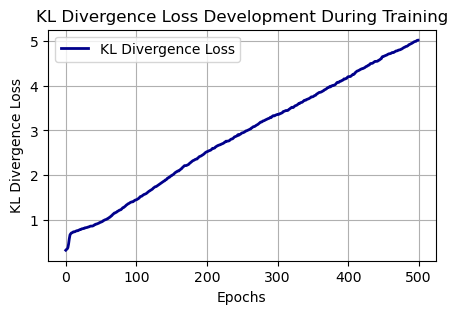

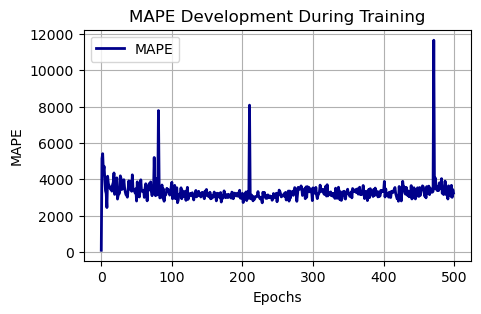

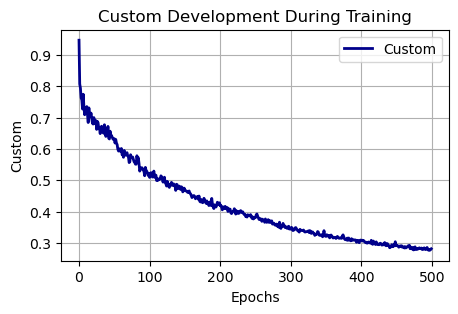

In [232]:
from plotting import plot_loss_development

loss_lists = [mse_list, mse_val_list, rmse_list, weighted_mse_list, kl_list, mape_list, custom_loss_list]
# loss_lists = [mse_list, mean_mse_list, kl_list, rmse_list, weighted_mse_list]
loss_names = ['MSE Loss', 'MSE Validation Loss', 'RMSE', 'Weighted MSE Loss', 'KL Divergence Loss', 'MAPE', 'Custom']
# loss_names = ['MSE Loss', 'Mean MSE Loss', 'KL Divergence Loss', 'RMSE', 'Custom MSE Loss']

# Define a path to save the plots, if needed
save_path = 'trainedModels' # Example path, change it as needed

plot_loss_development(loss_lists, loss_names, save_path, color='darkblue', model_name=model_name, figsize=(5, 3))

In [233]:
####### save model #######
# define model name

#saving the whole model
torch.save(model, 'trainedModels\\'+model_name+'.pth')

#saving just the weights and biases
#torch.save(model.state_dict(), 'trainedModels\\'+name_training_run+'.pth')

## 4. Model evaluation
- load model
- On training data:

    a. evaluate prediction perfromance

    b. evaluate uncertanty calibration

- On validation data:

    a. evaluate prediction perfromance

    b. evaluate uncertanty calibration

- On test data: 

    a. evaluate prediction perfromance

    b. evaluate uncertanty calibration
    


In [8]:
## load a model
model_name="steel_1001_1002_1003_no0_6_20_rmse_weighted_mse_400_300_1"
model = torch.load('trainedModels/_selected_steel/'+model_name+'.pth')

model.eval() # sets the model to evaluation mode, which affects layers like dropout and batch normalization that behave differently during training and inference.
model

C:\Users\Antoine\AppData\Local\Temp\ipykernel_16676\910815158.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('trainedModels/_selected_steel/'+model_n

Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=20, bias=True)
  (1): ReLU()
  (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=1, bias=True)
  (5): ReLU()
)

In [9]:
from plotting import plot_true_vs_pred, single_para_strudy_perf
from MLmodel import bnn_predict_with_uncertainty, calculate_rmse, filter_values_within_range, calculate_mape, calculate_custom_loss, evaluate_model_performance

### On training data



In [10]:
# make predictions and caluclate mean 
##### make predictions ####3
# Define number of predictions
n_predictions = 1000
# Perfrom multiple predictions on data --> get mean and std for each data point
y_train_mean_pred_np, y_train_std_pred_np, y_train_pred_n_times = bnn_predict_with_uncertainty(model, x_train_scaled_tensor, n=n_predictions, log_transform_back=False)

In [11]:
sub_dict_name='training_set_performance'

# initialize model dict
eval_dict[model_name]={} 
eval_dict[model_name]['model_settings']={}
eval_dict[model_name]['training_set_performance']={}
eval_dict[model_name]['validation_set_performance']={}

# eval_dict=evaluate_model_performance(y_true=y_train_np, y_pred=y_train_mean_pred_np,
#                                       dict_name=dict_name, model_name=model_name, eval_dict=eval_dict)
# eval_dict

In [12]:
# uncertanty evaluation

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#y_pred_mean=
#y_pred_std


# Define a range of confidence levels
confidence_levels = np.linspace(0, 1, 100)
coverages = []

# Compute prediction intervals (e.g., 95% confidence intervals) (Assumption that the predictive distribution is a normal dirtsibution)
for confidence_level in confidence_levels:
    z = norm.ppf((1 + confidence_level) / 2)  # z-score for the confidence level
    prediction_intervals = np.array([
        [meanPred - z * std, meanPred + z * std]
        for meanPred, std in zip(y_train_mean_pred_np, y_train_std_pred_np)
    ])

    # Check if actual values fall within prediction intervals
    within_intervals = np.array([
        interval[0] <= y_true <= interval[1]
        for interval, y_true in zip(prediction_intervals, y_train_np)
    ])
    
    # Proportion of times actual values fall within prediction intervals
    coverage = np.mean(within_intervals)
    coverages.append(coverage)

#print(coverages)

from sklearn.metrics import mean_squared_error
# Calculate Expected Calibration Error (ECE)
ece = np.mean(np.abs(confidence_levels - coverages))
#print("Expected Calibration Error (ECE):", ece)

# Calculate Total Calibration Error (TCE)
tce = np.sum(np.abs(confidence_levels - coverages))
# print("Total Calibration Error (TCE):", tce)

# Calculate Bias (Positive for Overconfidence, Negative for Underconfidence)
bias = np.sum(confidence_levels - coverages)
# print("Calibration Bias:", bias)

# safe to dict
eval_dict[model_name][sub_dict_name]['ECE']=ece
eval_dict[model_name][sub_dict_name]['TCE']=tce
eval_dict[model_name][sub_dict_name]['CB']=bias

C:\Users\Antoine\AppData\Local\Temp\ipykernel_16676\318454530.py:19: RuntimeWarning: invalid value encountered in multiply
  [meanPred - z * std, meanPred + z * std]


In [13]:
#print perfromances on training set
eval_dict[model_name][sub_dict_name]

{'ECE': 0.4586391414517813, 'TCE': 45.86391414517813, 'CB': 45.86391414517813}

### on validation set

In [14]:
##### make predictions ####
# Define number of predictions
n_predictions = 1000

# Perfrom multiple predictions on data --> get mean and std for each data point
y_val_mean_pred_np, y_val_std_pred_np, y_val_pred_n_times = bnn_predict_with_uncertainty(model, x_val_scaled_tensor, n=n_predictions,log_transform_back=False)


In [15]:
sub_dict_name='validation_set_performance'
# eval_dict=evaluate_model_performance(y_true=y_val_np, y_pred=y_val_mean_pred_np,
#                                       dict_name=dict_name, model_name=model_name, eval_dict=eval_dict)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Define a range of confidence levels
confidence_levels = np.linspace(0, 1, 100)
coverages = []

# Compute prediction intervals (e.g., 95% confidence intervals) (Assumption that the predictive distribution is a normal dirtsibution)
for confidence_level in confidence_levels:
    z = norm.ppf((1 + confidence_level) / 2)  # z-score for the confidence level
    prediction_intervals = np.array([
        [meanPred - z * std, meanPred + z * std]
        for meanPred, std in zip(y_val_mean_pred_np, y_val_std_pred_np)
    ])

    # Check if actual values fall within prediction intervals
    within_intervals = np.array([
        interval[0] <= y_true <= interval[1]
        for interval, y_true in zip(prediction_intervals, y_val_np)
    ])
    
    # Proportion of times actual values fall within prediction intervals
    coverage = np.mean(within_intervals)
    coverages.append(coverage)

print(coverages)


# Calculate Expected Calibration Error (ECE)
ece = np.mean(np.abs(confidence_levels - coverages))
print("Expected Calibration Error (ECE):", ece)

# Calculate Total Calibration Error (TCE)
tce = np.sum(np.abs(confidence_levels - coverages))
print("Total Calibration Error (TCE):", tce)

# Calculate Bias (Positive for Overconfidence, Negative for Underconfidence)
bias = np.sum(confidence_levels - coverages)
print("Calibration Bias:", bias)

# safe to dict
eval_dict[model_name][sub_dict_name]['ECE']=ece
eval_dict[model_name][sub_dict_name]['TCE']=tce
eval_dict[model_name][sub_dict_name]['CB']=bias

[0.0, 0.0, 0.0, 0.0010395010395010396, 0.0010395010395010396, 0.0031185031185031187, 0.0031185031185031187, 0.0031185031185031187, 0.0031185031185031187, 0.0031185031185031187, 0.004158004158004158, 0.005197505197505198, 0.005197505197505198, 0.005197505197505198, 0.006237006237006237, 0.007276507276507277, 0.007276507276507277, 0.007276507276507277, 0.007276507276507277, 0.008316008316008316, 0.008316008316008316, 0.008316008316008316, 0.008316008316008316, 0.009355509355509356, 0.010395010395010396, 0.010395010395010396, 0.010395010395010396, 0.010395010395010396, 0.011434511434511435, 0.011434511434511435, 0.011434511434511435, 0.011434511434511435, 0.011434511434511435, 0.011434511434511435, 0.012474012474012475, 0.012474012474012475, 0.013513513513513514, 0.014553014553014554, 0.014553014553014554, 0.014553014553014554, 0.014553014553014554, 0.014553014553014554, 0.014553014553014554, 0.014553014553014554, 0.014553014553014554, 0.016632016632016633, 0.016632016632016633, 0.0166320

C:\Users\Antoine\AppData\Local\Temp\ipykernel_16676\1754365956.py:14: RuntimeWarning: invalid value encountered in multiply
  [meanPred - z * std, meanPred + z * std]


In [17]:
#print perfromances on validation set
eval_dict[model_name][sub_dict_name]

{'ECE': 0.46108108108108103,
 'TCE': 46.108108108108105,
 'CB': 46.108108108108105}

## 5. Uncertainty recalibration

In [18]:
import uncertainty_toolbox as uct


# Set plot style
uct.viz.set_style()
uct.viz.update_rc("text.usetex", True)  # Set to True for system latex
uct.viz.update_rc("font.size", 12)  # Set font size
uct.viz.update_rc("xtick.labelsize", 12)  # Set font size for xaxis tick labels
uct.viz.update_rc("ytick.labelsize", 12)  # Set font size for yaxis tick labels

### On training set

In [19]:
train_pred_mean = y_train_mean_pred_np.flatten()
train_pred_std = y_train_std_pred_np.flatten()

y_train = y_train_np.flatten()

check whether there are stds = 0.0

In [20]:
print(np.where(train_pred_std == 0.0)[0])

[4799]


Replace those with a dummy 1e-3 value (**Run only if needed !!!**)

In [21]:
train_pred_std[np.where(train_pred_std == 0.0)[0]] = 1e-3

Recalibration

Before Recalibration:  
 MACE: 0.45864,
 RMSCE: 0.53170,
 MA: 0.46327


<Axes: title={'center': 'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

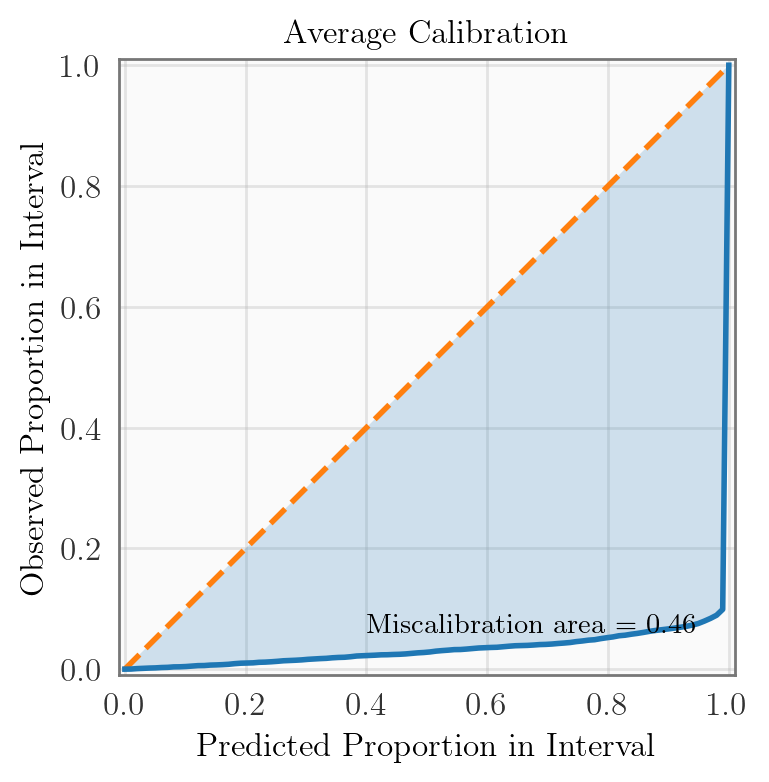

In [22]:
# Before recalibration
exp_props, obs_props = uct.get_proportion_lists_vectorized(
    train_pred_mean, train_pred_std, y_train
)
mace = uct.mean_absolute_calibration_error(
    train_pred_mean, train_pred_std, y_train, recal_model=None
)
rmsce = uct.root_mean_squared_calibration_error(
    train_pred_mean, train_pred_std, y_train, recal_model=None
)
ma = uct.miscalibration_area(train_pred_mean, train_pred_std, y_train, recal_model=None)
print("Before Recalibration:  \n", end="")
print(" MACE: {:.5f},\n RMSCE: {:.5f},\n MA: {:.5f}".format(mace, rmsce, ma))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
uct.plot_calibration(
    train_pred_mean,
    train_pred_std,
    y_train,
    exp_props=exp_props,
    obs_props=obs_props,
    ax=ax,
)

In [23]:
optim_ratio = uct.optimize_recalibration_ratio(
    train_pred_mean, train_pred_std, y_train
)
print(optim_ratio)

26.61865532226877


Before Recalibration:  
 MACE: 0.03614,
 RMSCE: 0.05311,
 MA: 0.03650


<Axes: title={'center': 'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

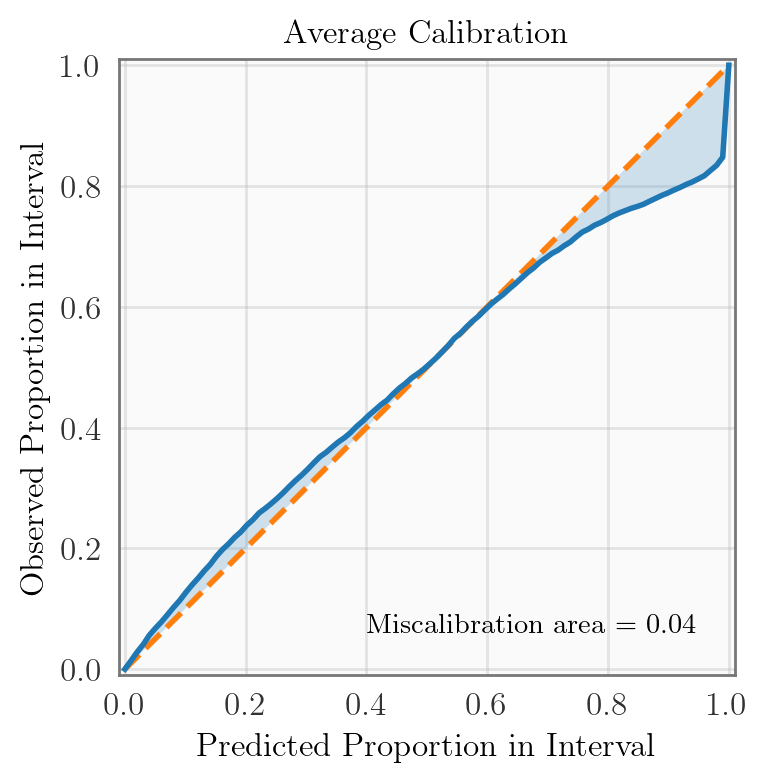

In [24]:
# Intermediate recalibration
exp_props, obs_props = uct.get_proportion_lists_vectorized(
    train_pred_mean, optim_ratio*train_pred_std, y_train
)
mace = uct.mean_absolute_calibration_error(
    train_pred_mean, optim_ratio*train_pred_std, y_train, recal_model=None
)
rmsce = uct.root_mean_squared_calibration_error(
    train_pred_mean, optim_ratio*train_pred_std, y_train, recal_model=None
)
ma = uct.miscalibration_area(train_pred_mean, optim_ratio*train_pred_std, y_train, recal_model=None)
print("Before Recalibration:  \n", end="")
print(" MACE: {:.5f},\n RMSCE: {:.5f},\n MA: {:.5f}".format(mace, rmsce, ma))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
uct.plot_calibration(
    train_pred_mean,
    train_pred_std,
    y_train,
    exp_props=exp_props,
    obs_props=obs_props,
    ax=ax,
)

In [25]:
recal_model = uct.iso_recal(exp_props, obs_props)

After Recalibration:  
 MACE: 0.00947,
 RMSCE: 0.02749,
 MA: 0.00951


<Axes: title={'center': 'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

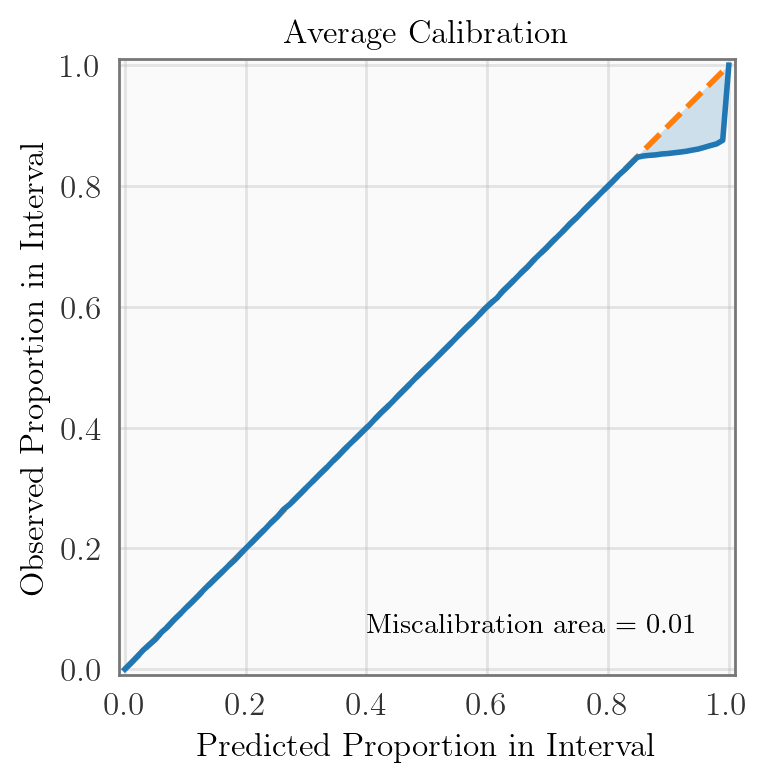

In [26]:
# After recalibration
recal_exp_props, recal_obs_props = uct.get_proportion_lists_vectorized(
    train_pred_mean, optim_ratio*train_pred_std, y_train, recal_model=recal_model
)
mace = uct.mean_absolute_calibration_error(
    train_pred_mean, optim_ratio*train_pred_std, y_train, recal_model=recal_model
)
rmsce = uct.root_mean_squared_calibration_error(
    train_pred_mean, optim_ratio*train_pred_std, y_train, recal_model=recal_model
)
ma = uct.miscalibration_area(train_pred_mean, optim_ratio*train_pred_std, y_train, recal_model=recal_model)
print("After Recalibration:  \n", end="")
print(" MACE: {:.5f},\n RMSCE: {:.5f},\n MA: {:.5f}".format(mace, rmsce, ma))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
uct.plot_calibration(
    train_pred_mean,
    train_pred_std,
    y_train,
    exp_props=recal_exp_props,
    obs_props=recal_obs_props,
    ax=ax,
)

### On validation set

In [27]:
val_pred_mean = y_val_mean_pred_np.flatten()
val_pred_std = y_val_std_pred_np.flatten()

y_val = y_val_np.flatten()

check whether there are stds = 0.0

In [28]:
print(np.where(val_pred_std == 0.0)[0])

[220 469]


Replace those with a dummy 1e-3 value (**Run only if needed !!!**)

In [29]:
val_pred_std[np.where(val_pred_std == 0.0)[0]] = 1e-3

Recalibration

Before Recalibration:  
 MACE: 0.46106,
 RMSCE: 0.53306,
 MA: 0.46572


<Axes: title={'center': 'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

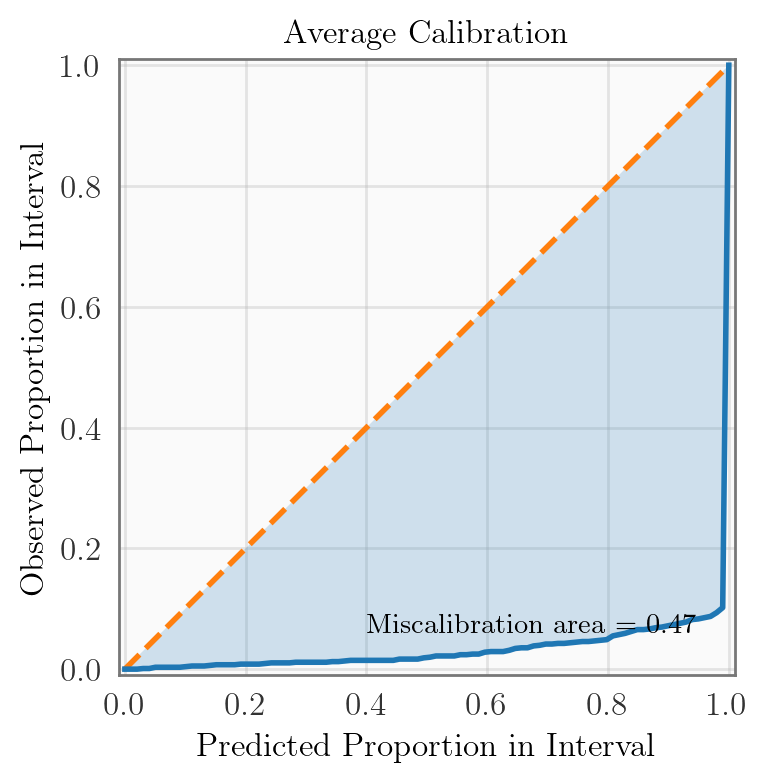

In [30]:
# Before recalibration
exp_props, obs_props = uct.get_proportion_lists_vectorized(
    val_pred_mean, val_pred_std, y_val
)
mace = uct.mean_absolute_calibration_error(
    val_pred_mean, val_pred_std, y_val, recal_model=None
)
rmsce = uct.root_mean_squared_calibration_error(
    val_pred_mean, val_pred_std, y_val, recal_model=None
)
ma = uct.miscalibration_area(val_pred_mean, val_pred_std, y_val, recal_model=None)
print("Before Recalibration:  \n", end="")
print(" MACE: {:.5f},\n RMSCE: {:.5f},\n MA: {:.5f}".format(mace, rmsce, ma))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
uct.plot_calibration(
    val_pred_mean,
    val_pred_std,
    y_val,
    exp_props=exp_props,
    obs_props=obs_props,
    ax=ax,
)

Before Recalibration:  
 MACE: 0.05822,
 RMSCE: 0.07465,
 MA: 0.05879


<Axes: title={'center': 'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

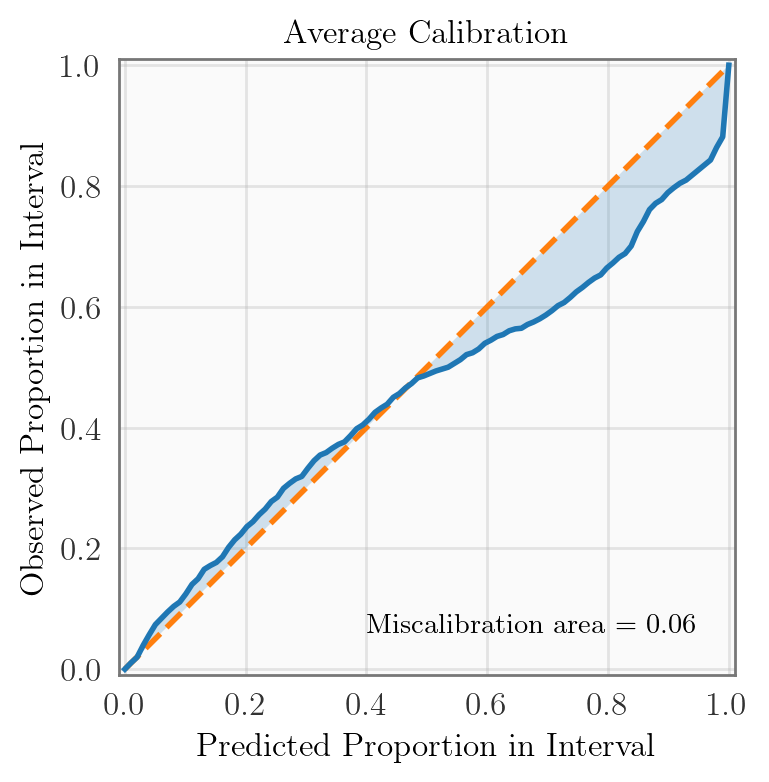

In [31]:
# Intermediate recalibration
exp_props, obs_props = uct.get_proportion_lists_vectorized(
    val_pred_mean, optim_ratio*val_pred_std, y_val
)
mace = uct.mean_absolute_calibration_error(
    val_pred_mean, optim_ratio*val_pred_std, y_val, recal_model=None
)
rmsce = uct.root_mean_squared_calibration_error(
    val_pred_mean, optim_ratio*val_pred_std, y_val, recal_model=None
)
ma = uct.miscalibration_area(val_pred_mean, optim_ratio*val_pred_std, y_val, recal_model=None)
print("Before Recalibration:  \n", end="")
print(" MACE: {:.5f},\n RMSCE: {:.5f},\n MA: {:.5f}".format(mace, rmsce, ma))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
uct.plot_calibration(
    val_pred_mean,
    val_pred_std,
    y_val,
    exp_props=exp_props,
    obs_props=obs_props,
    ax=ax,
)

After Recalibration:  
 MACE: 0.02626,
 RMSCE: 0.04034,
 MA: 0.02642


<Axes: title={'center': 'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

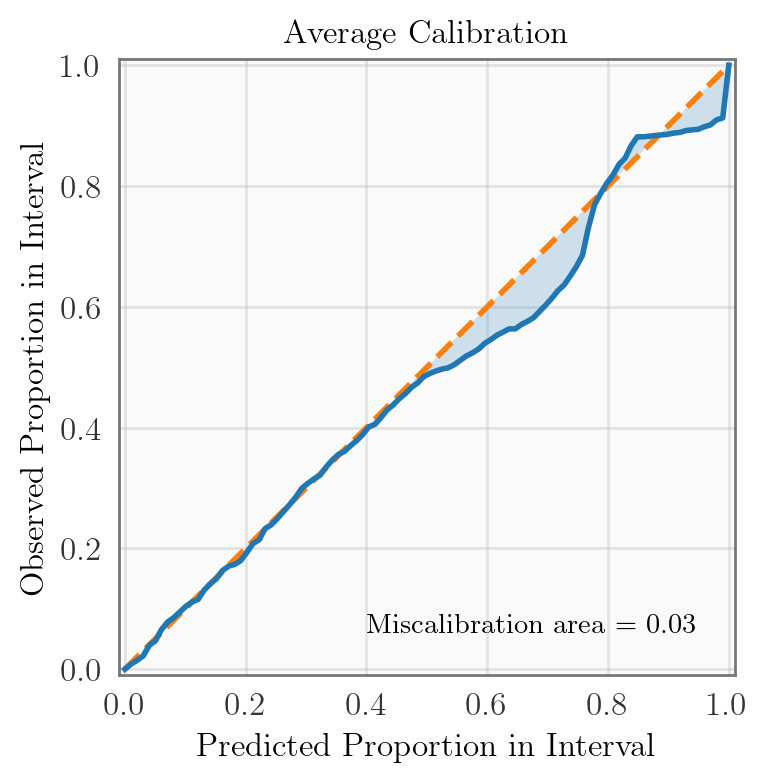

In [32]:
# After recalibration
recal_exp_props, recal_obs_props = uct.get_proportion_lists_vectorized(
    val_pred_mean, optim_ratio*val_pred_std, y_val, recal_model=recal_model
)
mace = uct.mean_absolute_calibration_error(
    val_pred_mean, optim_ratio*val_pred_std, y_val, recal_model=recal_model
)
rmsce = uct.root_mean_squared_calibration_error(
    val_pred_mean, optim_ratio*val_pred_std, y_val, recal_model=recal_model
)
ma = uct.miscalibration_area(val_pred_mean, optim_ratio*val_pred_std, y_val, recal_model=recal_model)
print("After Recalibration:  \n", end="")
print(" MACE: {:.5f},\n RMSCE: {:.5f},\n MA: {:.5f}".format(mace, rmsce, ma))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
uct.plot_calibration(
    val_pred_mean,
    val_pred_std,
    y_val,
    exp_props=recal_exp_props,
    obs_props=recal_obs_props,
    ax=ax,
)

### See results

In [46]:
def validation_1DParameter_study_with_recalibration(idx_s, x_names, scaler, model, recal_model, var_par,  unit, eta, n_predictions=100):

    # get 1D parameter study data
    xy_file_name='CFBData\\{}_Batch\\{}_CFB_xy.csv'.format(idx_s,idx_s)
    df_xy=pd.read_csv(xy_file_name)
    #print(df_xy)

    #Extract features
    x_df=df_xy[x_names]

    #Scale them
    x_scaled_np = scaler.transform(x_df)
    x_scaled_df=pd.DataFrame(data=x_scaled_np, columns=scaler.get_feature_names_out())

    #transform into tensor
    x_1D_tensor=torch.tensor(x_scaled_df.values, dtype=torch.float32)

    ##### make predictions ####
    # Perfrom multiple predictions on data --> get mean and std for each data point
    val_mean_pred_1d, val_std_pred_1d, y_val_pred_n_times_1d = bnn_predict_with_uncertainty(model, x_1D_tensor, n=n_predictions)

    #plot
    cm = 1/2.54

    fig, axes = plt.subplots(1,2,figsize=(60*cm,15*cm))

    #Bending
    axes[0].plot(df_xy[var_par], df_xy[eta], label='Concrete NLFE-Analysis', marker='x', color='black')

    #Prediction
    axes[0].plot(df_xy[var_par], val_mean_pred_1d[:,0], label='Concrete Mean Model \nPrediction', marker='.', color='green')

    #Confidence
    axes[0].fill_between(df_xy[var_par], val_mean_pred_1d[:,0] - 3*val_std_pred_1d[:,0], val_mean_pred_1d[:,0] + 3*val_std_pred_1d[:,0], label = "99.7$\%$ Confidence interval \nConcrete", color = "green", alpha = 0.3)

    #TODO later if we have also shear and reinforcement eta model plot all in one (only ms=1)??
    # #Shear
    # ax.plot(df_xy_1[var_par], df_xy_1['eta_min_shear'],label='Shear stress (ms=1t)', marker='o', color='orangered')
    # ax.plot(df_xy_1[var_par], df_xy_1['eta_min_shear_reduced'],label='Shear stress within bounds   \n(ms=1t)', marker='o', color='deeppink')

    axes[0].set(xlabel=var_par+unit, ylabel='$\eta \ min$ [-]', title='Concrete Frame Bridge, Studie {}'.format(idx_s))


    # upper_lim = 25
    # ax.set_ylim(bottom=0,top=upper_lim)
    axes[0].axhline(y=1, color='red', linestyle='--', linewidth=1, label='$\eta=1$')

    axes[0].set_xticks(df_xy[var_par])
    labels = axes[0].get_xticklabels()
    axes[0].set_xticklabels(labels, rotation=45)

    #ax.set_yticks(np.linspace(0,upper_lim,11))

    
    axes[0].grid(True)
    axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

    #Recalibrated part
    val_std_pred_1d = optim_ratio*val_std_pred_1d
    recal_bounds = uct.metrics_calibration.get_prediction_interval(val_mean_pred_1d.flatten(), val_std_pred_1d.flatten(), 0.997, recal_model)
    #Bending
    axes[1].plot(df_xy[var_par], df_xy[eta], label='Concrete NLFE-Analysis', marker='x', color='black')

    #Prediction
    axes[1].plot(df_xy[var_par], val_mean_pred_1d[:,0], label='Concrete Mean Model \nPrediction', marker='.', color='green')

    #Confidence
    axes[1].fill_between(df_xy[var_par], recal_bounds.lower, recal_bounds.upper, label = "99.7$\%$ Confidence interval \nConcrete - Recalibrated", color = "green", alpha = 0.3)

    #TODO later if we have also shear and reinforcement eta model plot all in one (only ms=1)??
    # #Shear
    # ax.plot(df_xy_1[var_par], df_xy_1['eta_min_shear'],label='Shear stress (ms=1t)', marker='o', color='orangered')
    # ax.plot(df_xy_1[var_par], df_xy_1['eta_min_shear_reduced'],label='Shear stress within bounds   \n(ms=1t)', marker='o', color='deeppink')

    axes[1].set(xlabel=var_par+unit, ylabel='$\eta \ min$ [-]', title='Concrete Frame Bridge, Studie {}'.format(idx_s))


    # upper_lim = 25
    # ax.set_ylim(bottom=0,top=upper_lim)
    axes[1].axhline(y=1, color='red', linestyle='--', linewidth=1, label='$\eta=1$')

    axes[1].set_xticks(df_xy[var_par])
    labels = axes[1].get_xticklabels()
    axes[1].set_xticklabels(labels, rotation=45)

    #ax.set_yticks(np.linspace(0,upper_lim,11))

    
    axes[1].grid(True)
    axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    fig.tight_layout()

<>:34: SyntaxWarning: invalid escape sequence '\%'
<>:41: SyntaxWarning: invalid escape sequence '\e'
<>:46: SyntaxWarning: invalid escape sequence '\e'
<>:68: SyntaxWarning: invalid escape sequence '\%'
<>:75: SyntaxWarning: invalid escape sequence '\e'
<>:80: SyntaxWarning: invalid escape sequence '\e'
<>:34: SyntaxWarning: invalid escape sequence '\%'
<>:41: SyntaxWarning: invalid escape sequence '\e'
<>:46: SyntaxWarning: invalid escape sequence '\e'
<>:68: SyntaxWarning: invalid escape sequence '\%'
<>:75: SyntaxWarning: invalid escape sequence '\e'
<>:80: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Antoine\AppData\Local\Temp\ipykernel_15480\2607339691.py:34: SyntaxWarning: invalid escape sequence '\%'
  axes[0].fill_between(df_xy[var_par], val_mean_pred_1d[:,0] - 3*val_std_pred_1d[:,0], val_mean_pred_1d[:,0] + 3*val_std_pred_1d[:,0], label = "99.7$\%$ Confidence interval \nConcrete", color = "green", alpha = 0.3)
C:\Users\Antoine\AppData\Local\Temp\ipykernel_15480\260733

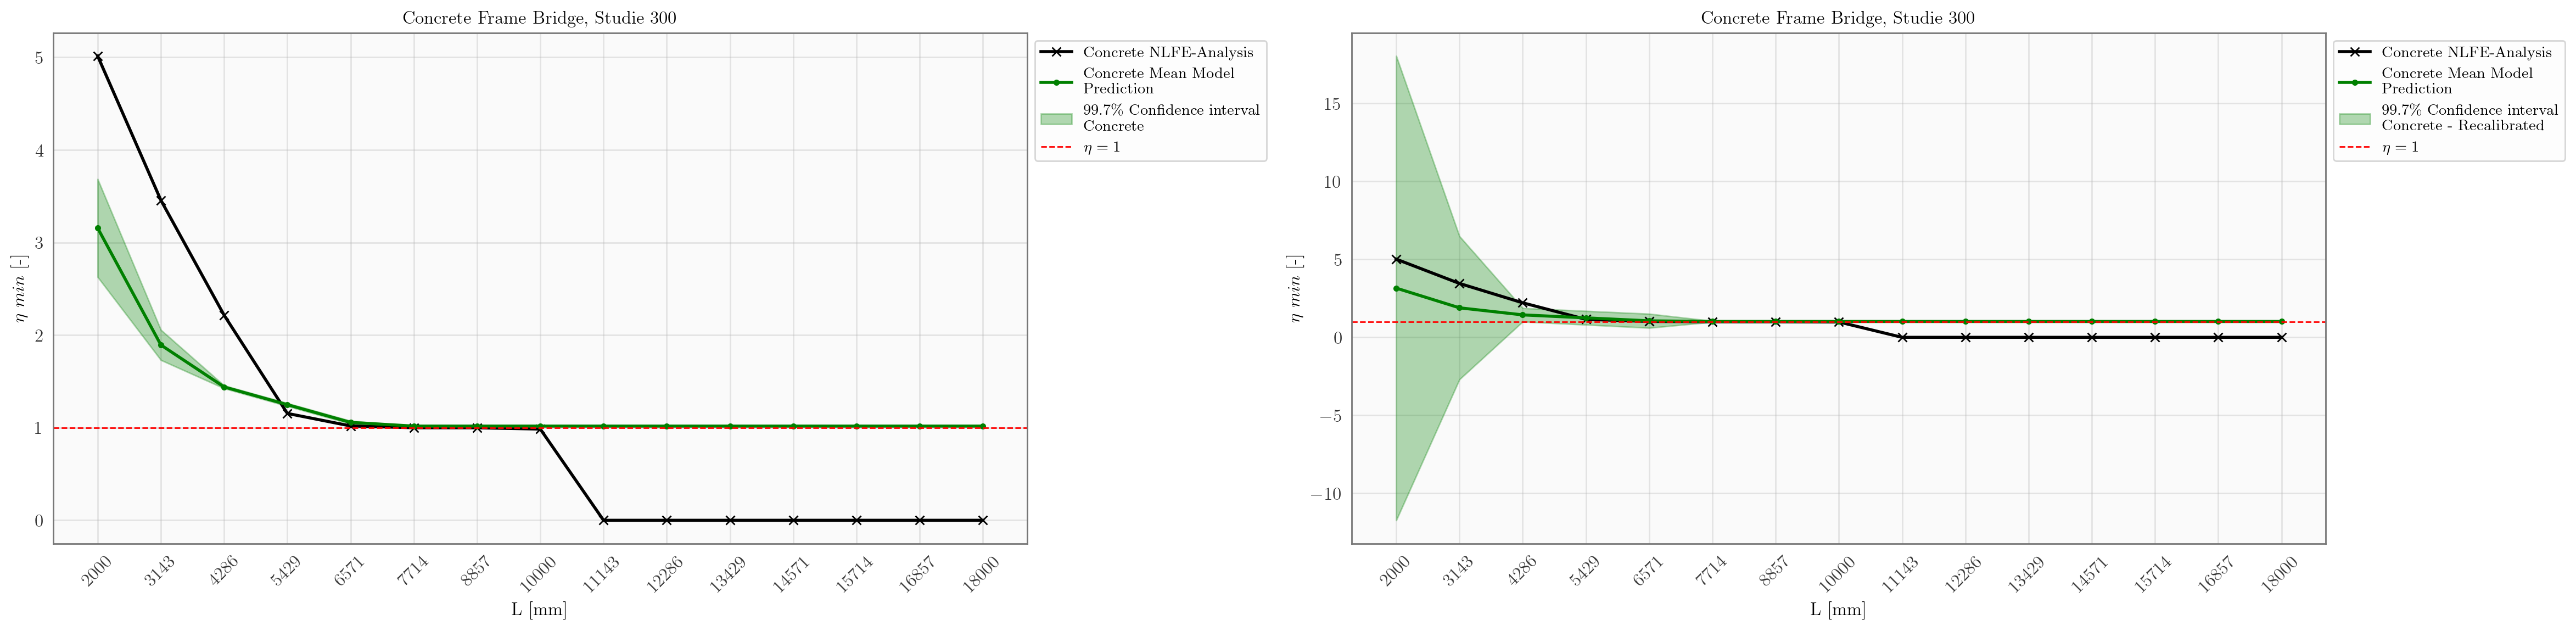

In [47]:
idx_s=300
var_par='L'
unit=' [mm]'
eta='eta_min_s'

validation_1DParameter_study_with_recalibration(idx_s, x_names, scaler, model, recal_model, var_par,  unit, eta)

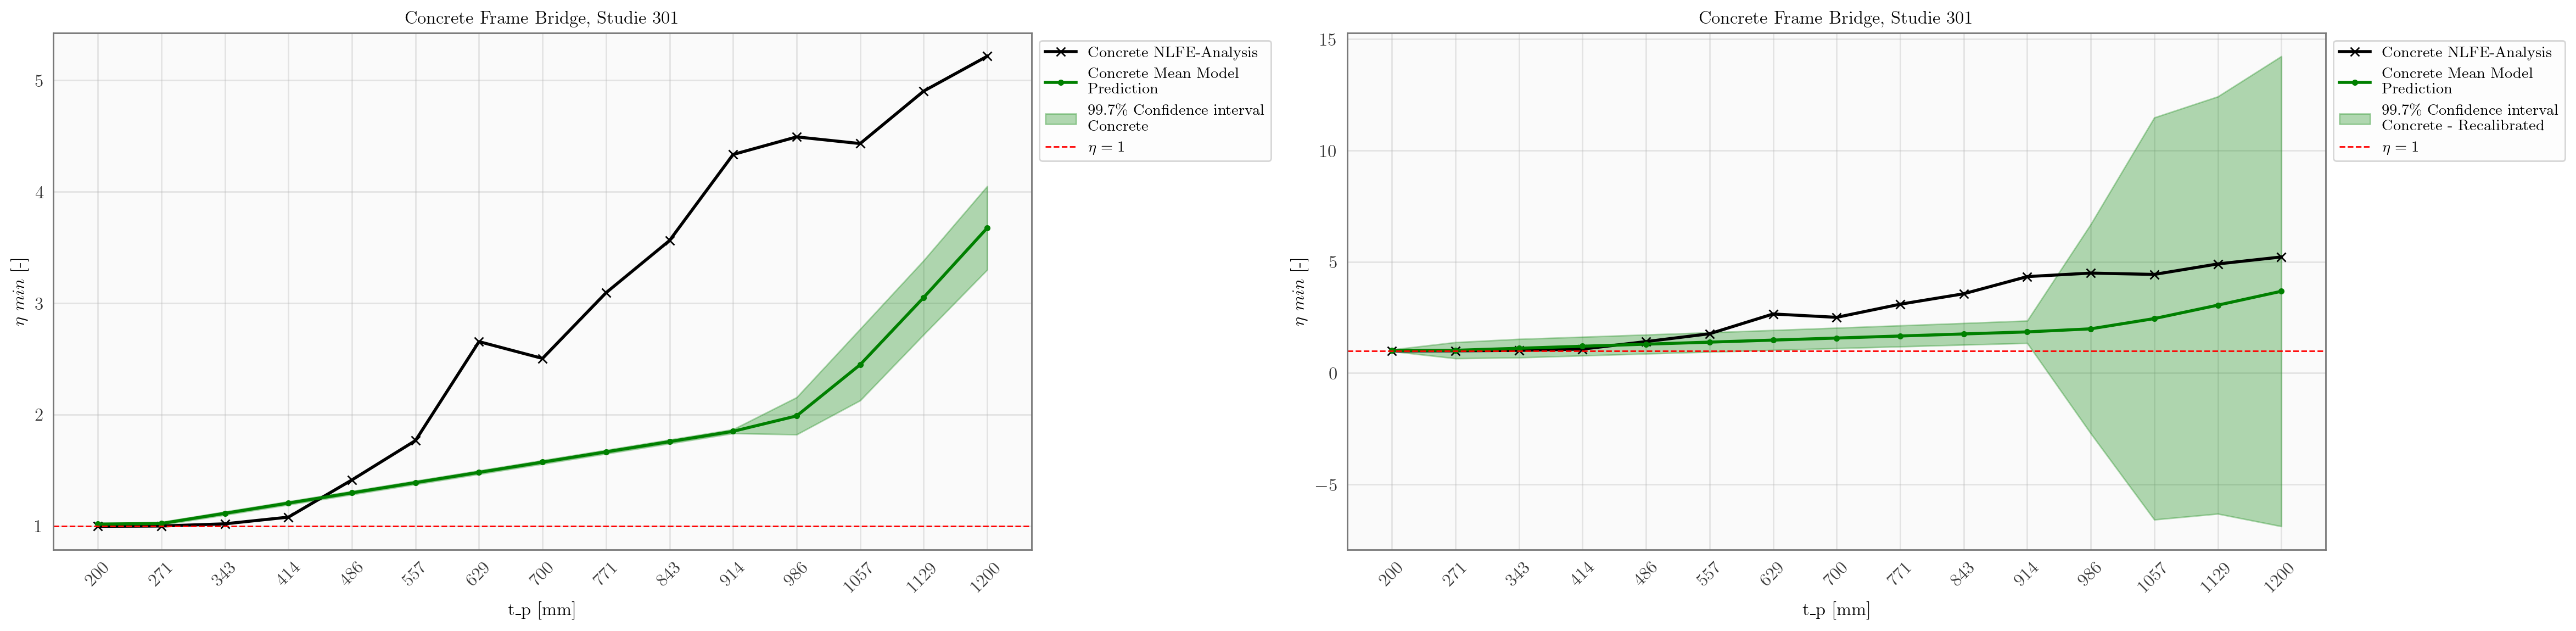

In [48]:
idx_s=301
var_par='t_p'
unit=' [mm]'
eta='eta_min_s'

validation_1DParameter_study_with_recalibration(idx_s, x_names, scaler, model, recal_model, var_par,  unit, eta)

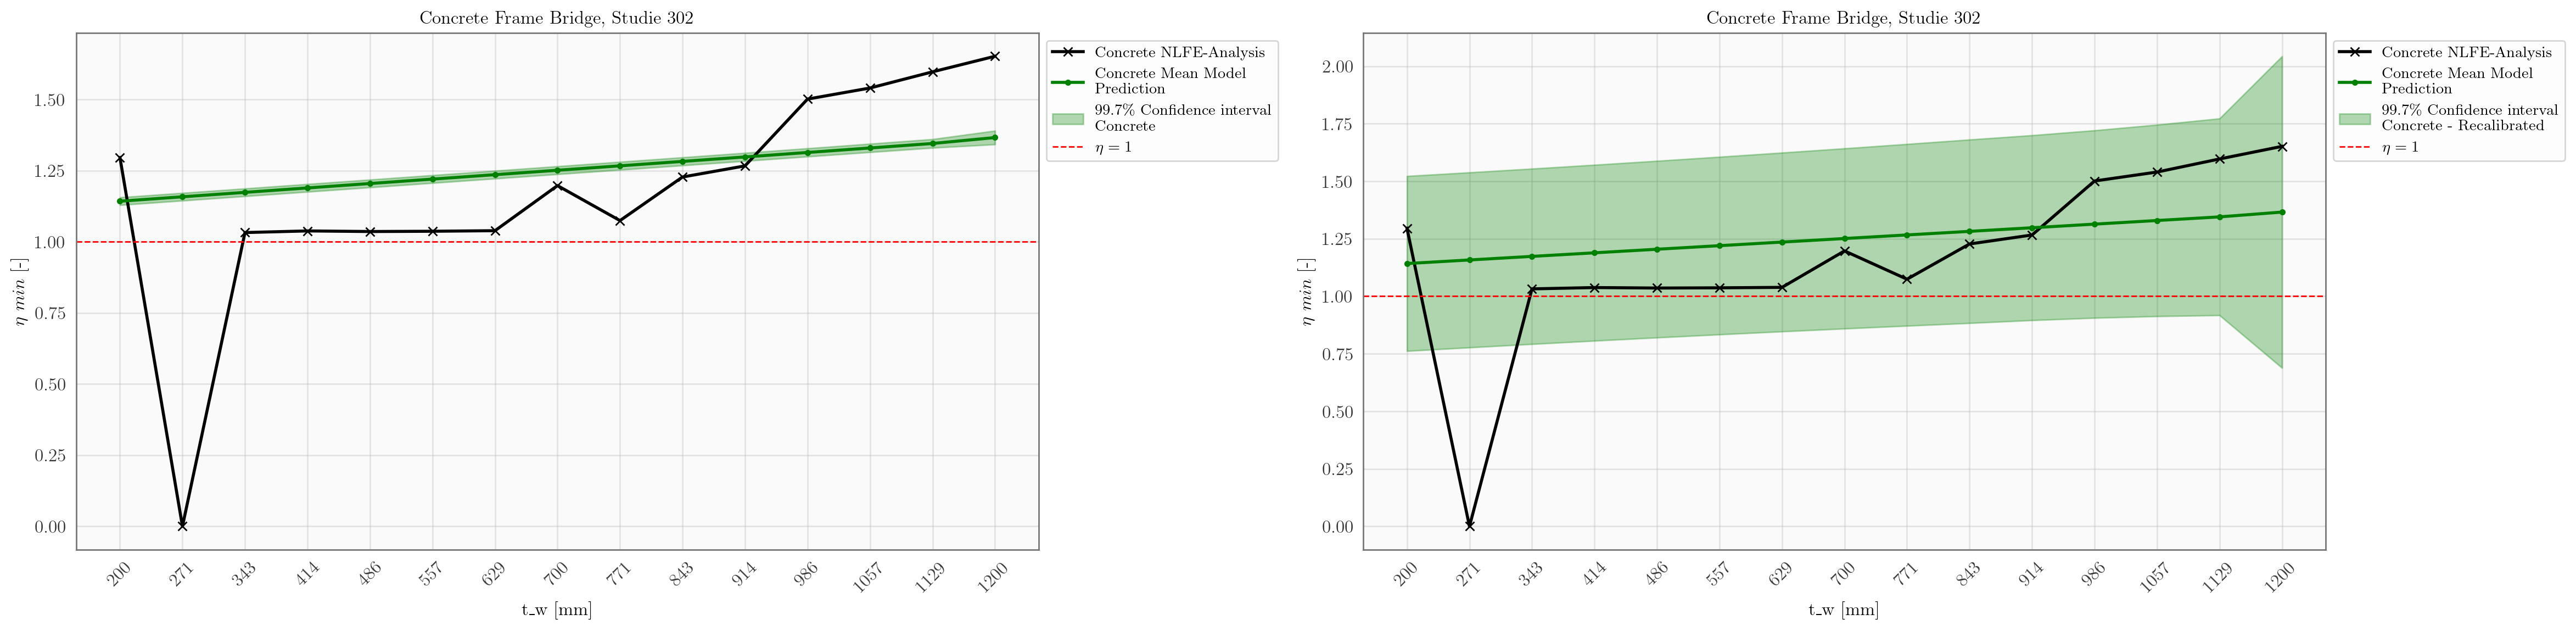

In [49]:
idx_s=302
var_par='t_w'
unit=' [mm]'
eta='eta_min_s'

validation_1DParameter_study_with_recalibration(idx_s, x_names, scaler, model, recal_model, var_par,  unit, eta)

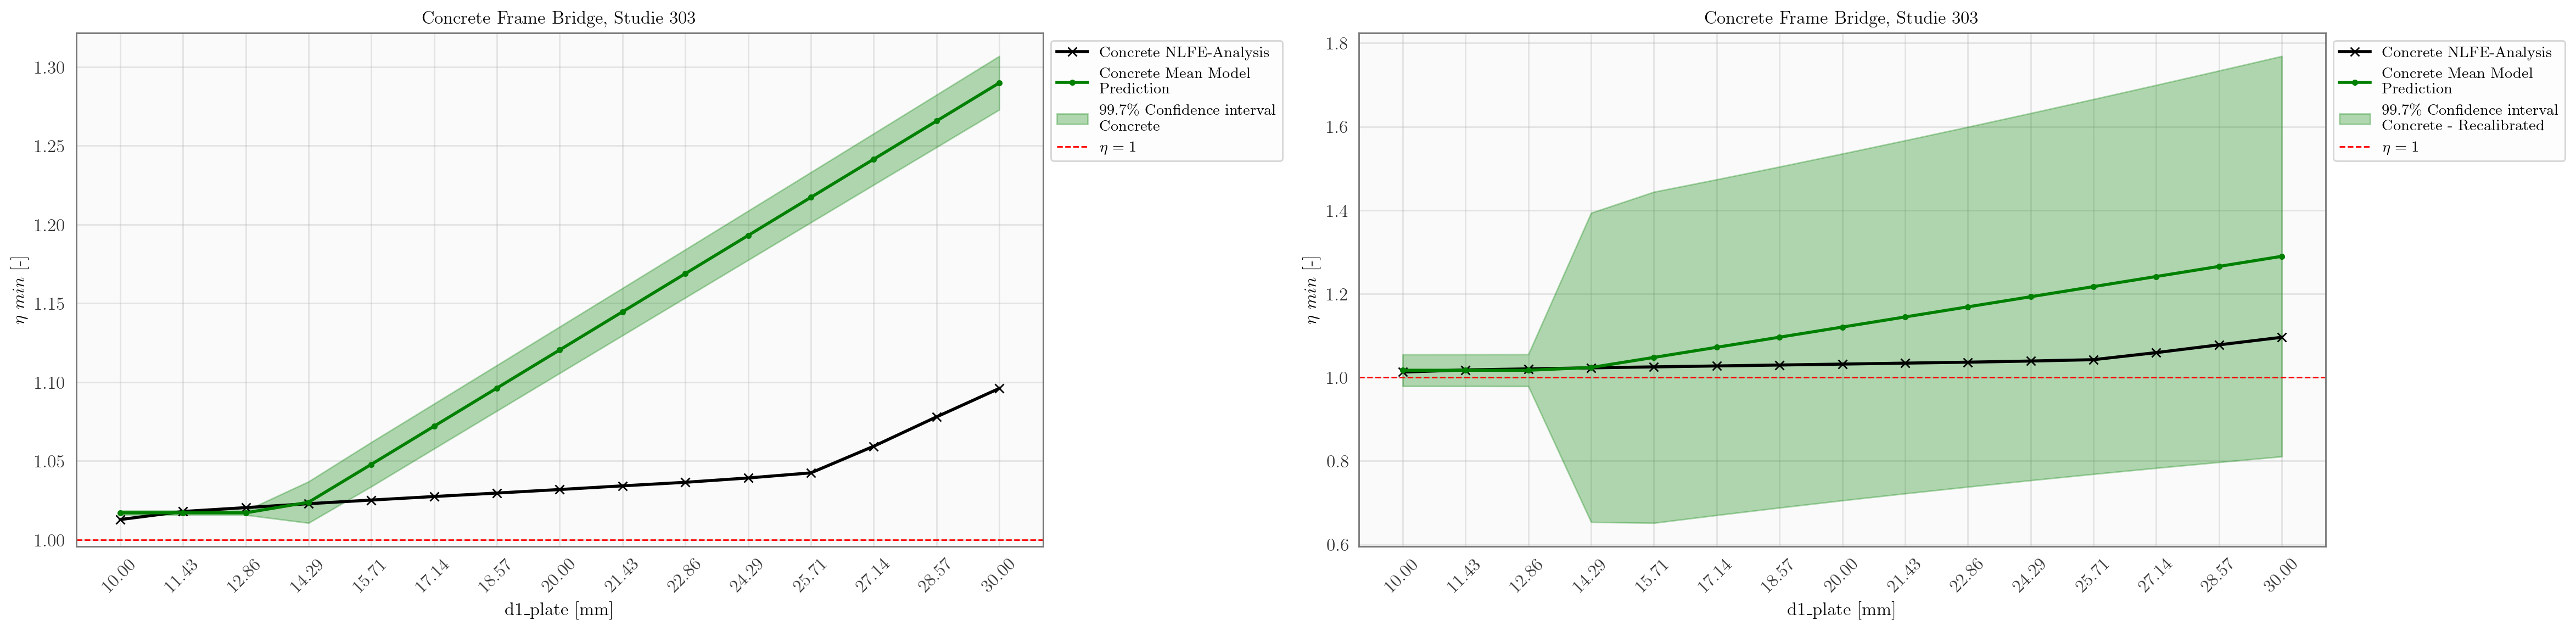

In [50]:
idx_s=303
var_par='d1_plate'
unit=' [mm]'
eta='eta_min_s'

validation_1DParameter_study_with_recalibration(idx_s, x_names, scaler, model, recal_model, var_par,  unit, eta)

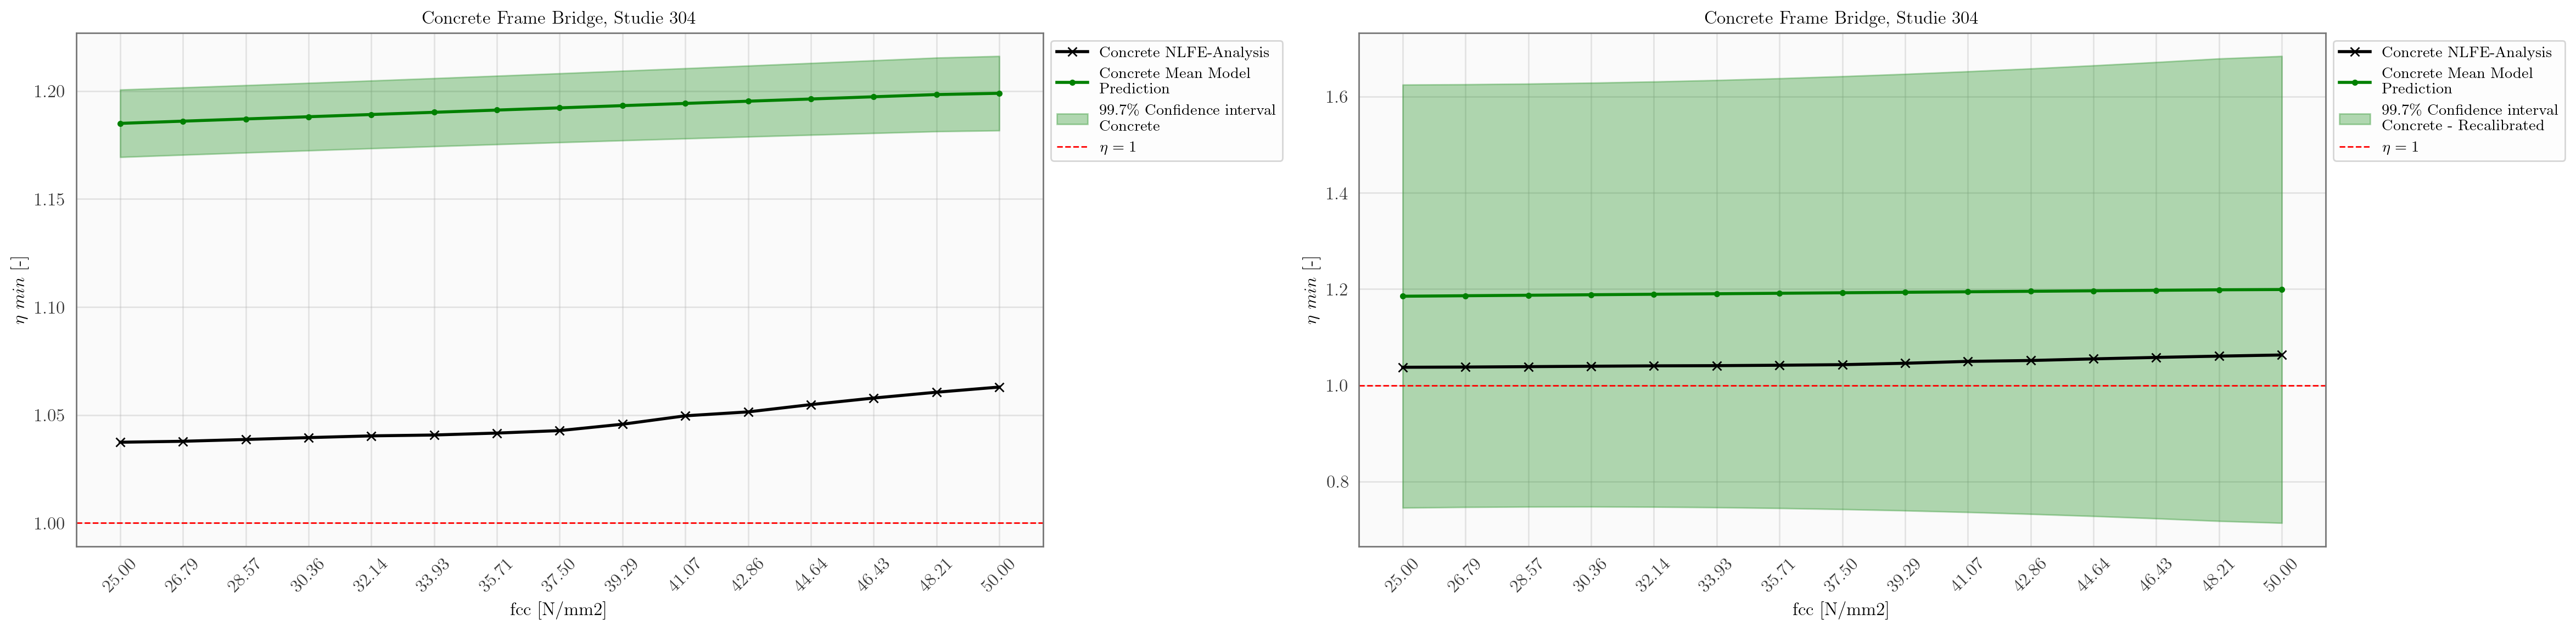

In [51]:
idx_s=304
var_par='fcc'
unit=' [N/mm2]'
eta='eta_min_s'

validation_1DParameter_study_with_recalibration(idx_s, x_names, scaler, model, recal_model, var_par,  unit, eta)

## Save dict

In [245]:
# #naming
# dict_name='Study_0_Antoine'
# # Saving the dictionary to a JSON file
# with open('trainedModels\\{}.json'.format(dict_name), 'w') as file:
#     json.dump(eval_dict, file, indent=4)